# Theory

Neste notebook temos a implementação do QMM para calibrar probabilidades de default condicionais usando dados de rating e scores.
O objetivo é modelar a relação entre os scores de crédito e taxas de default observadas, ajustando-se a métricas como central tendency e a accuracy ratio.


Verificaram também que não há ratings e scores nulos.


No código são também implementadas 2 classes:

•	**LDPortfolio: Nesta classe é calculado métricas como o accuracy ratio (AR) e a central tendency (CT) a partir da distribuição do portfolio.**

•	**QMM:**

- Classe que implementa o método QMM para calibrar as PDs condicionais, herdando da classe LDPortfolio.

-  Aqui são desenvolvidos 2 static methods (**Robust Logit** vs Logit Simples) como curvas de calibrar. O método robust usa um CDF normal inverso em vez do score direto. Isto transforma a distribuição dos ratings numa dist normal, tornando o modelo mais estável e menos sensíveis a outliers na distribuição de scores. 

- É usado um solver “fsolve” para resolver um sistema de equações não-lineares, com o objetivo de encontrar os parâmetros alpha e beta de modo que a CT do modelo = CT target e AR do modelo = AR target. Isto é um processo iterativo que vai ajustando as curvas até que as métricas observadas coinicidam com os targets.
    

------------------------------------------


**Funções principais:**

•	prepare_portfolio() – Prepara os dados para análise, agregando por score.

•	run_QMM() - Executa todo o fluxo do modelo QMM, desde a preparação dos dados até à visualização dos resultados e gráficos.

1 – Preparação: Agrupa dados por score e calcula PDs empíricas 

2 – Baseline model: Cálculo de métricas do modelo atual (AR/CT observadas)

3 – Calibração: Aplica QMM para atingir CT target mantendo AR

4 – Validação: Compara PDs observadas vs modeladas

5 – Output: Geração de resultados por rating e score e por desafio.





## Libraries

In [2]:
import numpy as np
from statsmodels import distributions
from scipy.optimize import fsolve
from scipy import stats
from operator import sub
import math
import matplotlib.pyplot as plt
import pandas as pd

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 4, Finished, Available, Finished)

## Read data

In [24]:
df = pd.read_csv("/lakehouse/default/Files/WorkerFactory/RDS_GDM_CC_INPUT.csv", sep=';')
df = df[df['Rating_Final_Corrected'] != 'MISSING']
df = df[df['R_ST'] == 'Rated']
df

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 26, Finished, Available, Finished)

,Posicao,DTPOSICAO,I_Est_Def12m_PES_FINAL,Rating_Final_Corrected,Score_Corrected,undrawn,R_ST,DES1,DES2,DES3,DES4,DES5,DES6
0,201012,31DEC2010:00:00:00,0,bb,6.21,Drawn,Rated,1,1,1,1,1,bb
1,201012,31DEC2010:00:00:00,0,b,7.62,Undrawn,Rated,1,0,1,1,0,b
2,201012,31DEC2010:00:00:00,1,ccc+,8.29,Drawn,Rated,1,1,1,1,1,ccc+
3,201012,31DEC2010:00:00:00,0,bb+,5.96,Drawn,Rated,1,1,1,1,1,bb+
4,201012,31DEC2010:00:00:00,0,a-,3.51,Undrawn,Rated,1,0,1,1,0,a-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19591,202312,31DEC2023:00:00:00,0,b+,7.16,Drawn,Rated,1,1,1,1,1,b+
19592,202312,31DEC2023:00:00:00,0,bb-,6.87,Drawn,Rated,1,1,1,1,1,bb-
19593,202312,31DEC2023:00:00:00,0,b-,8.06,Drawn,Rated,1,1,1,1,1,b-
19594,202312,31DEC2023:00:00:00,0,b,7.74,Drawn,Rated,1,1,1,1,1,b


In [25]:
df['Rating_Final_Corrected'].value_counts()

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 27, Finished, Available, Finished)

Rating_Final_Corrected
b+      2767
bb+     2298
bb      2244
bb-     2230
b       1789
bbb-    1676
ccc+    1223
b-      1169
bbb      256
ccc      134
a-        60
lccc      42
bbb+      32
a+        14
a          2
Name: count, dtype: int64

In [26]:
df.info()

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 28, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 15936 entries, 0 to 19595
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 15936 non-null  int64  
 1   DTPOSICAO               15936 non-null  object 
 2   I_Est_Def12m_PES_FINAL  15936 non-null  int64  
 3   Rating_Final_Corrected  15936 non-null  object 
 4   Score_Corrected         15936 non-null  float64
 5   undrawn                 15936 non-null  object 
 6   R_ST                    15936 non-null  object 
 7   DES1                    15936 non-null  int64  
 8   DES2                    15936 non-null  int64  
 9   DES3                    15936 non-null  int64  
 10  DES4                    15936 non-null  int64  
 11  DES5                    15936 non-null  int64  
 12  DES6                    15936 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usage: 1.7+ MB


## Function: prepare portfolio
Esta função:

Limpa os dados com nulos nas colunas essenciais.
Agrupa por score e calcula:
número total de contratos (count)
número de defaults (bads)
número de não-defaults (goods)
PD empírica condicional (pd_cnd) por score.
O dicionário retornado será é usado como input para modelar a relação entre score e PD.

In [8]:
def prepare_portfolio(df, rating_col, score_col, default_col):

    df_clean = df.dropna(subset=[rating_col, score_col, default_col])

    grp = df_clean.groupby(score_col).agg(count=(default_col, 'size'), bads=('I_Est_Def12m_PES_FINAL', 'sum')).sort_values(score_col, ascending=False)
    grp['goods'] = grp['count']-grp['bads']
    categories = grp.index.tolist()
    portfolio = grp['count'].values
    goods = grp['goods'].values
    pd_cnd = (df_clean.groupby(score_col)[default_col].mean().reindex(categories).tolist())

    return{'portfolio': tuple(portfolio), 'goods': tuple(goods), 'pd_cnd': pd_cnd, 'mapping': categories}

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 10, Finished, Available, Finished)

In [9]:
# ver output em dataframe
data = prepare_portfolio(df, 'Rating_Final_Corrected', 'Score_Corrected', 'I_Est_Def12m_PES_FINAL')

df_view = pd.DataFrame({
    "Rating": data['mapping'],
    "Portfolio": data['portfolio'],
    "Goods": data['goods'],
    "Bads": [p - g for p, g in zip(data['portfolio'], data['goods'])],
    "PD_cnd": data['pd_cnd']
})

df_view

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 11, Finished, Available, Finished)

,Rating,Portfolio,Goods,Bads,PD_cnd
0,10.00,42,23,19,0.452381
1,9.85,2,2,0,0.000000
2,9.67,1,1,0,0.000000
3,9.60,3,3,0,0.000000
4,9.58,15,12,3,0.200000
...,...,...,...,...,...
523,3.51,1,1,0,0.000000
524,3.50,57,57,0,0.000000
525,3.21,2,2,0,0.000000
526,3.07,2,2,0,0.000000


# Class LDP e QMM

In [10]:
class LDPortfolio:
    """
    Basic functionality for all LDP calibration facilities.
    :attribute self.ar: Estimated Accuracy ratio given portfolio distribution and PD values
    :attribute self.ct: Central Tendency (mean PD) ratio given portfolio distribution and PD values
    """
    def __init__(self, portfolio, goods, pd_cnd):
        """
        :param portfolio: Unconditional portfolio distribution from the worst to the best credit quality;

        :param pd_cnd: Current conditional PD distribution from the worst to the best credit quality. Could be used
                            for current AR estimation.
        """
        self.portfolio = np.array(portfolio)
        self.goods = np.array(goods)
        self.pd_cnd = np.array(pd_cnd)

        self.portfolio_size = self.portfolio.sum()
        self.portfolio_dist = self.portfolio.cumsum() / self.portfolio_size
        self.portfolio_dist = (np.hstack((0, self.portfolio_dist[:-1])) + self.portfolio_dist) / 2
        self.rating_prob = self.portfolio / self.portfolio_size

        self.goods_size = self.goods.sum()
        self.goods_dist = self.goods.cumsum() / self.goods_size
        self.goods_dist = (np.hstack((0, self.goods_dist[:-1])) + self.goods_dist) / 2
        self.goods_rating_prob = self.goods / self.goods_size

        self.ct = None
        self.ar = None
        if not pd_cnd is None:
            self.ct, self.ar = self._ar_estimate(self.pd_cnd)

    def _ar_estimate(self, pd_cnd):
        ct = self.rating_prob.T.dot(pd_cnd)
        ar_1int_1 = self.rating_prob * pd_cnd
        ar_1int_1 = np.hstack((0, ar_1int_1[:-1]))
        ar_1int_1 =  (1 - pd_cnd) * self.rating_prob * ar_1int_1.cumsum()
        ar_1 = 2 * ar_1int_1.sum()
        ar_2 =  (1 - pd_cnd) * pd_cnd * self.rating_prob * self.rating_prob
        ar = (ar_1 + ar_2.sum()) * (1.0 / (ct * (1 - ct))) - 1
        return ct, ar.sum()



class QMM(LDPortfolio):
    """
    Calibrates conditional probabilities of default according to Quasi Moment Matching algorithm
    :attribute self.pd_cnd: calibrated conditional PD
    :attribute self.alpha: intercept calibration parameter
    :attribute self.beta: slope calibration parameter
    """
    def __init__(self, portfolio, goods, clb_curve = 'robust.logit', portfolio_cnd_no_dft = None):
        """
        :param portfolio: Unconditional portfolio distribution from the worst to the best credit quality;

        :param clb_curve: In case ’logit’, simple logit calibration curve is used (is applicable only for
                        rating_type = ’SCORE’). In case ’robust.logit’, robust logit function is used
                        (see Tasche D.(2013) for details).
        :param portfolio_cnd_no_dft: conditional on no default portfolio distribution (in case None, unconditional
                                    portfolio distribution is used as a proxy)
        :return: initialized QMM class object
        """

        super().__init__(portfolio, goods, pd_cnd=None)
        if portfolio_cnd_no_dft is None:
            self.portfolio_cnd_no_dft = self.goods
        else:
            self.portfolio_cnd_no_dft = self.portfolio_cnd_no_dft
        self.clb_curve = clb_curve
        self.alpha = None
        self.beta = None

    def fit(self, ct_target, ar_target):
        """
        :param ct_target: target Central Tendency
        :param ar_target: target Accuracy Ratio
        :return: calibrated QMM class
        """
        a = self.__get_pd((0, 0))
        tf = lambda x: tuple(map(sub, self._ar_estimate(self.__get_pd(x)), (ct_target, ar_target)))
        params = fsolve(tf, (0, 0))
        self.alpha, self.beta = params
        self.pd_cnd = self.__get_pd(params)
        self.ct, self.ar = self._ar_estimate(self.pd_cnd)
        return self

    def __get_pd(self, params):
        if self.clb_curve == 'logit':
            return self._logit(self.portfolio, params)
        else:
            return self._robust_logit(self.goods_dist, params)

    @staticmethod
    def _robust_logit(x, params):
        alpha, beta = params
        return 1 / (1 + np.exp(- alpha - beta * stats.norm.ppf(x)))

    @staticmethod
    def _logit(x, params):
        alpha, beta = params
        return 1 / (1 + np.exp(- alpha - beta * x))

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 12, Finished, Available, Finished)

# Run QMM function

In [22]:
def run_QMM(output, df_input, LRADR_target, ar_target=None):

    # If ar_target is none, it considers the ar observed to the QMM
    info = prepare_portfolio(df_input, 'Rating_Final_Corrected', 'Score_Corrected', 'I_Est_Def12m_PES_FINAL')
    p1 = LDPortfolio(info['portfolio'], info['goods'], info['pd_cnd'])

    # Use provided AR target or fall back to observed
    target_ar = ar_target if ar_target is not None else p1.ar


    q1 = QMM(info['portfolio'], info['goods'])
    q1.fit(ct_target=LRADR_target, ar_target=target_ar) # can replace with own values as well but using observed values for illustrative purposes
    #print(q1.alpha)
    #print(q1.beta)

    observed_PD = info['pd_cnd']
    model_PD = q1.pd_cnd
    x_labels = info['mapping']

    ################################ PLOT ######################################

    # Cores Novo Banco
    verde_escuro = '#179297'
    verde_claro = 'pink'
    verde_medio = '#BFCE28'

    # Criar stilo de gráfico
    plt.figure(figsize=(12, 7))
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot das linhas 
    plt.plot(x_labels, observed_PD,
            label='Observed PD',
            marker='o',
            color=verde_escuro,
            linewidth=2,
            markersize=6,
            markerfacecolor=verde_escuro,
            markeredgecolor='white',
            markeredgewidth=1)

    plt.plot(x_labels, model_PD,
            label='QMM Modeled PD',
            marker='s',
            color=verde_claro,
            linewidth=2,
            markersize=6,
            markerfacecolor=verde_claro,
            markeredgecolor='white',
            markeredgewidth=0,
            linestyle='--')

    # Área sombreada entre as curvas
    plt.fill_between(x_labels, observed_PD, model_PD,
                    alpha=0.15,
                    color=verde_medio)

    # Títulos e labels
    plt.xlabel('Credit Score', fontsize=13, fontweight='bold')
    plt.ylabel('Probability of Default', fontsize=13, fontweight='bold')
    plt.title('Observed vs QMM Modelled PD', fontsize=18, fontweight='bold', color=verde_escuro, pad=15)

    # Legenda
    plt.legend(frameon=True,
              fancybox=True,
              shadow=True,
              fontsize=11,
              loc='upper right')

    # Grid e formatação
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(fontsize=11)

    # Formato percentual no eixo y
    from matplotlib.ticker import FuncFormatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1%}'))

    plt.tight_layout()
    plt.show()

    print("\n\n********************* DATA QUALITY CHECKS *********************\n")

    display(df_input.info())
    print("\n---------------------------------------------------------------\n")

    df_input['Rating_Final_Corrected'].value_counts()
    # DROP DE MISSINGS OU NÃO ????????
    nan_counts = df_input[df_input['Rating_Final_Corrected'] == 'MISSING'].shape[0]
    print(f"Rating_Final_Corrected Nº MISSINGS: {nan_counts}\n")
    nan_countsx = int(df_input[['Score_Corrected']].isna().sum().values[0])
    print(f"Score_Corrected Nº MISSINGS: {nan_countsx}\n")


    ########################### RESULTS ########################################

    print("\n********************* RESULTS *******************************\n\n")

    print(f"Observed CT: {p1.ct:.5f},    Target CT: {LRADR_target:.5f},    Diff: {p1.ct - LRADR_target:.3f}")
    print(f"Observed AR: {p1.ar:.5f},    Target AR: {target_ar:.5f},    Diff: {p1.ar - target_ar:.3f}\n")

    print("-----------------------------------------------------------------\n")

    print(f"QMM model PD: {q1.ct}\n")
    print(f"Observed PD: {LRADR_target}\n")
    print(f"Alpha: {q1.alpha}\n")
    print(f"Beta: {q1.beta}\n")
    print(f"Rating Model AR: {p1.ar}\n")
    print(f"QMM Model AR: {q1.ar}\n")

    
    ordem_ratings = ['a+', 'a', 'a-', 'bbb+', 'bbb', 'bbb-', 
                 'bb+', 'bb', 'bb-', 'b+', 'b', 'b-', 
                 'ccc+', 'ccc', 'lccc']


    # Save results
    qmm_results = pd.DataFrame({'Score_Corrected':info['mapping'], 'QMM':q1.pd_cnd})
    qmm_results = pd.merge(df_input, qmm_results, on="Score_Corrected", how="left")
    # save excel
    qmm_results.to_excel(f'''{output}.xlsx''')

    results = qmm_results.groupby('Rating_Final_Corrected').agg(n_obs=('I_Est_Def12m_PES_FINAL', 'size'), DR =('I_Est_Def12m_PES_FINAL', 'mean'), QMM = ('QMM','mean'))
    results['DR_p'] = results['DR']*100
    results['QMM_p'] = results['QMM']*100

    print("\n\n**************** FINAL RESULTS **********************************\n")

    results = results.reset_index()
    results['Rating_Final_Corrected'] = pd.Categorical(results['Rating_Final_Corrected'], categories=ordem_ratings, ordered=True)
    results = results.sort_values('Rating_Final_Corrected')
    
    display(results)

    display(qmm_results)

    return qmm_results, results.sort_values(by='QMM')

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 24, Finished, Available, Finished)

# Replica

In [20]:
df

StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 22, Finished, Available, Finished)

,Posicao,DTPOSICAO,I_Est_Def12m_PES_FINAL,Rating_Final_Corrected,Score_Corrected,undrawn,R_ST,DES1,DES2,DES3,DES4,DES5,DES6
0,201012,31DEC2010:00:00:00,0,bb,6.21,Drawn,Rated,1,1,1,1,1,bb
1,201012,31DEC2010:00:00:00,0,b,7.62,Undrawn,Rated,1,0,1,1,0,b
2,201012,31DEC2010:00:00:00,1,ccc+,8.29,Drawn,Rated,1,1,1,1,1,ccc+
3,201012,31DEC2010:00:00:00,0,bb+,5.96,Drawn,Rated,1,1,1,1,1,bb+
4,201012,31DEC2010:00:00:00,0,a-,3.51,Undrawn,Rated,1,0,1,1,0,a-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19591,202312,31DEC2023:00:00:00,0,b+,7.16,Drawn,Rated,1,1,1,1,1,b+
19592,202312,31DEC2023:00:00:00,0,bb-,6.87,Drawn,Rated,1,1,1,1,1,bb-
19593,202312,31DEC2023:00:00:00,0,b-,8.06,Drawn,Rated,1,1,1,1,1,b-
19594,202312,31DEC2023:00:00:00,0,b,7.74,Drawn,Rated,1,1,1,1,1,b


StatementMeta(, c7fb7c63-3a8d-480f-aba5-13c788c52fc5, 29, Finished, Available, Finished)

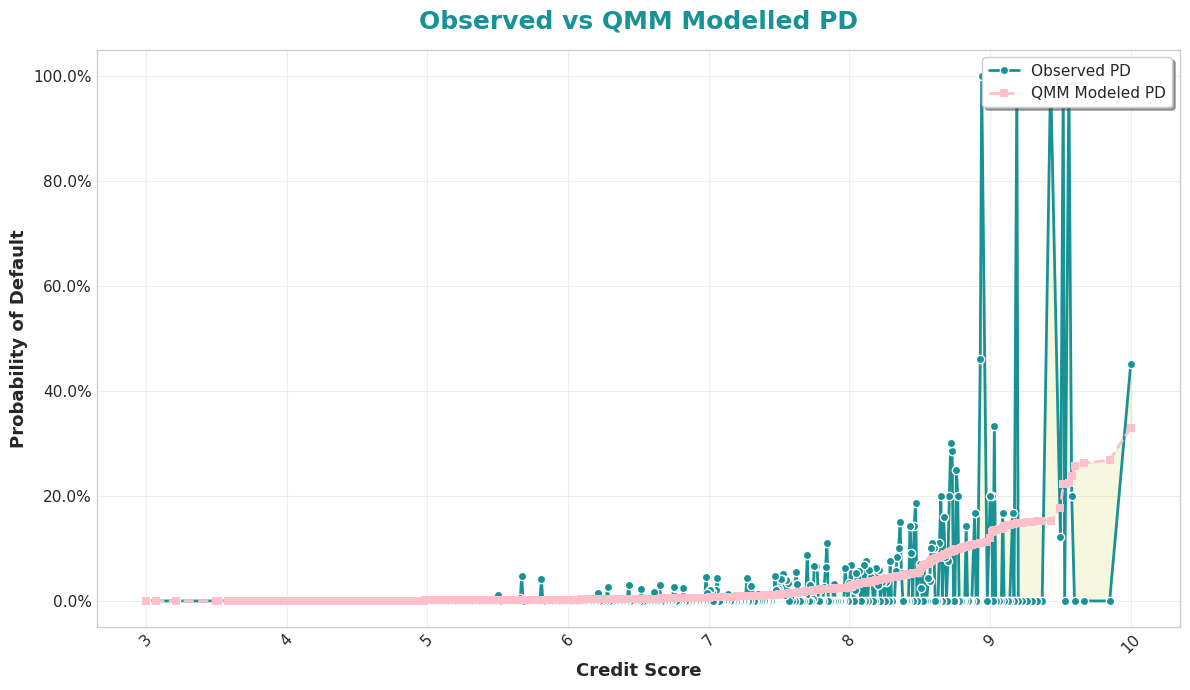



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 15936 entries, 0 to 19595
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 15936 non-null  int64  
 1   DTPOSICAO               15936 non-null  object 
 2   I_Est_Def12m_PES_FINAL  15936 non-null  int64  
 3   Rating_Final_Corrected  15936 non-null  object 
 4   Score_Corrected         15936 non-null  float64
 5   undrawn                 15936 non-null  object 
 6   R_ST                    15936 non-null  object 
 7   DES1                    15936 non-null  int64  
 8   DES2                    15936 non-null  int64  
 9   DES3                    15936 non-null  int64  
 10  DES4                    15936 non-null  int64  
 11  DES5                    15936 non-null  int64  
 12  DES6                    15936 non-null  object 
dtypes: float64(1), int64(7), obje

SynapseWidget(Synapse.DataFrame, 03b09017-ae73-4424-a1e1-976c2bc6612e)

SynapseWidget(Synapse.DataFrame, 1fa49303-3d0f-4c71-97da-baca07591b6c)

In [27]:
LRA_DR_replica = df.groupby("Posicao").agg(
    DR=('I_Est_Def12m_PES_FINAL', 'mean'),
    count=('I_Est_Def12m_PES_FINAL', 'size')
)["DR"].mean()

qmm_results, results = run_QMM(f"QMM portfolio", df, LRA_DR_replica, None)

# CHALLENGES RESULTS

*   Desafio 1 - Exclusão de todos os casos em que o máximo da exposição é 5000 euros
*   Desafio 2 - Exclusao de clientes de todos clientes que apenas tiveram saldos undrawn durante todo o horizonte temporal.
*   Desafio 3 - Considerar como central tendency rate target a long run dos clientes rated. 
*   Desafio 4 - Considerar apenas clientes rated e excluir todos os casos em que o máximo da exposição do cliente é 5000 euros
*   Desafio 5 - Considerar apenas clientes rated e drawn
*   Desafio 6 - Considerar apenas rating 12 meses antes do default


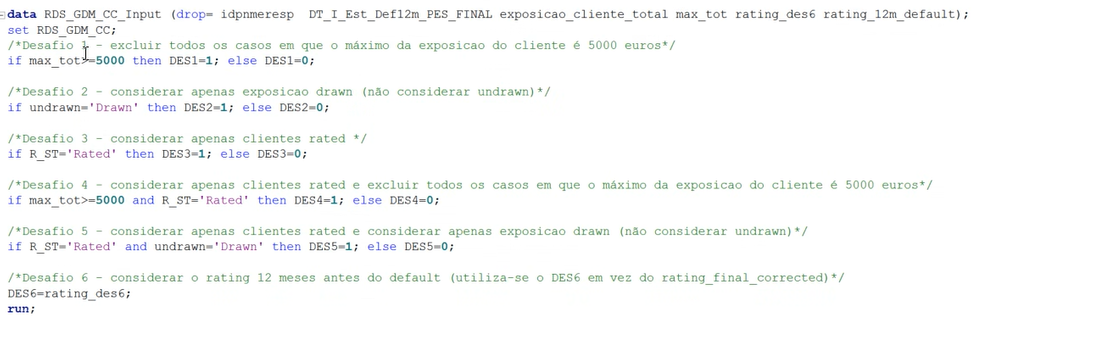

StatementMeta(, 7bdff5cd-2007-408f-9b34-f17b05f1cda6, 19, Finished, Available, Finished)




################### CHALLENGE DES1 ##########################


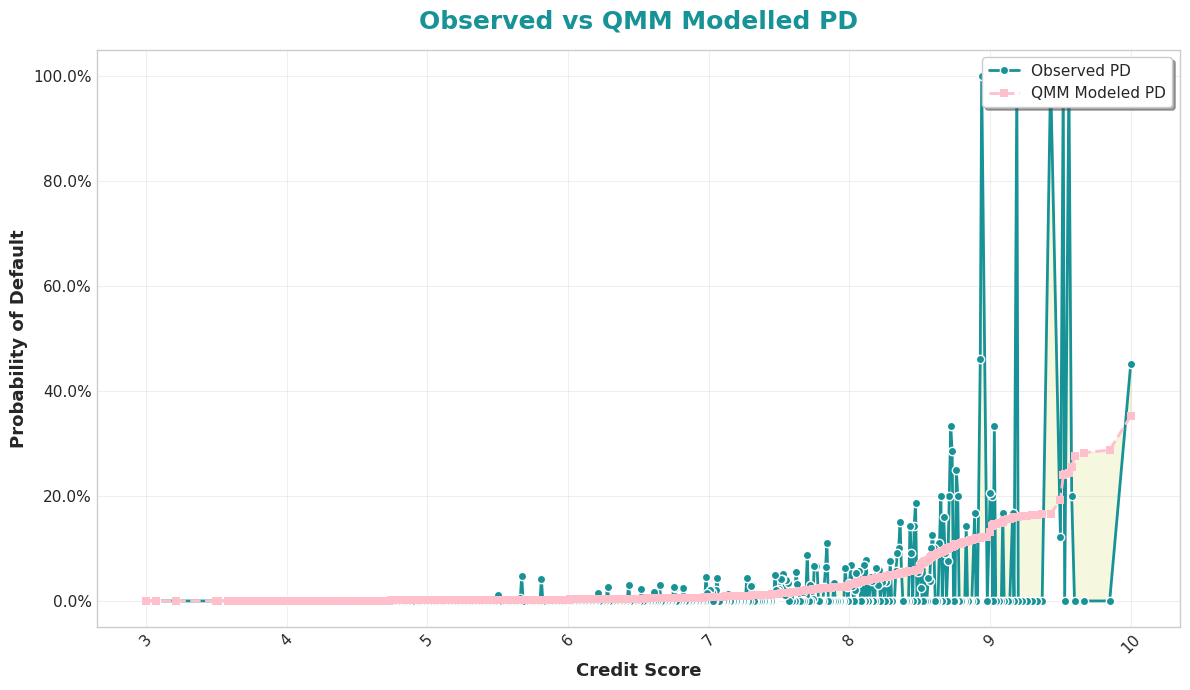



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 19134 entries, 0 to 19595
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 19134 non-null  int64  
 1   DTPOSICAO               19134 non-null  object 
 2   I_Est_Def12m_PES_FINAL  19134 non-null  int64  
 3   Rating_Final_Corrected  19134 non-null  object 
 4   Score_Corrected         15891 non-null  float64
 5   undrawn                 19134 non-null  object 
 6   R_ST                    19134 non-null  object 
 7   DES1                    19134 non-null  int64  
 8   DES2                    19134 non-null  int64  
 9   DES3                    19134 non-null  int64  
 10  DES4                    19134 non-null  int64  
 11  DES5                    19134 non-null  int64  
 12  DES6                    19134 non-null  object 
dtypes: float64(1), int64(7), obje

SynapseWidget(Synapse.DataFrame, 23af30d4-7f4e-421a-9aa4-48fc9add532f)

SynapseWidget(Synapse.DataFrame, 98623b73-5b8d-4866-9d79-f5e8fb679745)




################### CHALLENGE DES2 ##########################


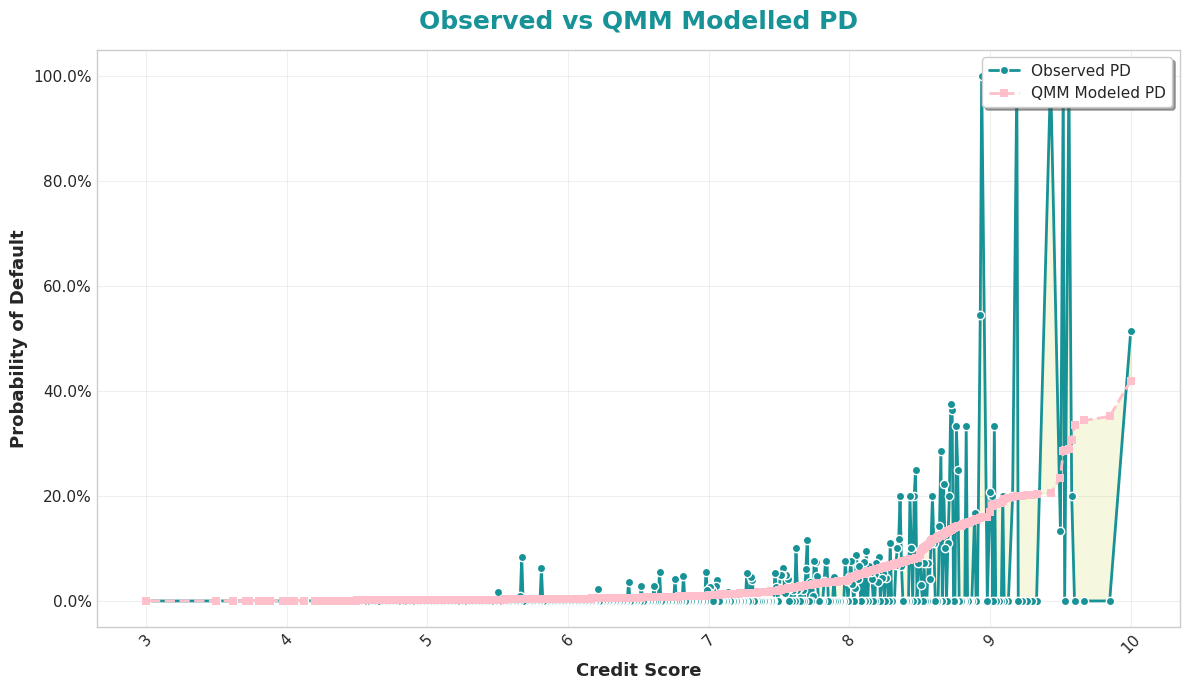



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 12817 entries, 0 to 19598
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 12817 non-null  int64  
 1   DTPOSICAO               12817 non-null  object 
 2   I_Est_Def12m_PES_FINAL  12817 non-null  int64  
 3   Rating_Final_Corrected  12817 non-null  object 
 4   Score_Corrected         10863 non-null  float64
 5   undrawn                 12817 non-null  object 
 6   R_ST                    12817 non-null  object 
 7   DES1                    12817 non-null  int64  
 8   DES2                    12817 non-null  int64  
 9   DES3                    12817 non-null  int64  
 10  DES4                    12817 non-null  int64  
 11  DES5                    12817 non-null  int64  
 12  DES6                    12817 non-null  object 
dtypes: float64(1), int64(7), obje

SynapseWidget(Synapse.DataFrame, 9701cd32-fade-4143-adbd-868d56db814d)

SynapseWidget(Synapse.DataFrame, af9df823-16da-4a31-9464-dad6e77851b3)




################### CHALLENGE DES3 ##########################


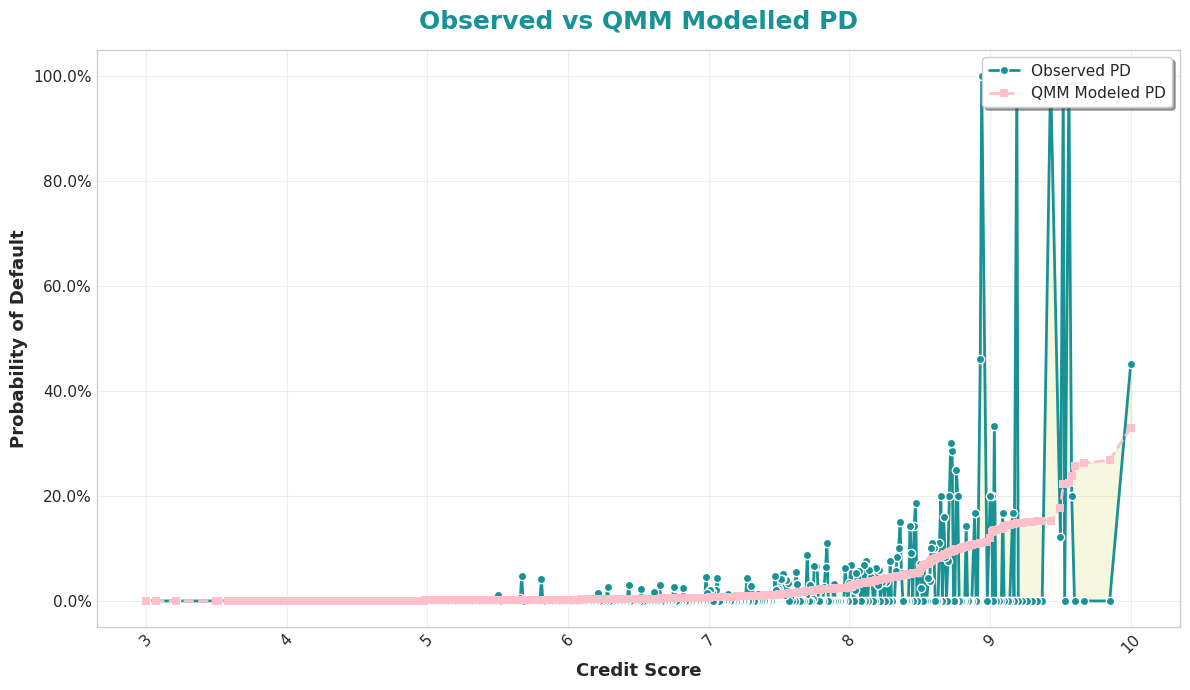



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 15936 entries, 0 to 19595
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 15936 non-null  int64  
 1   DTPOSICAO               15936 non-null  object 
 2   I_Est_Def12m_PES_FINAL  15936 non-null  int64  
 3   Rating_Final_Corrected  15936 non-null  object 
 4   Score_Corrected         15936 non-null  float64
 5   undrawn                 15936 non-null  object 
 6   R_ST                    15936 non-null  object 
 7   DES1                    15936 non-null  int64  
 8   DES2                    15936 non-null  int64  
 9   DES3                    15936 non-null  int64  
 10  DES4                    15936 non-null  int64  
 11  DES5                    15936 non-null  int64  
 12  DES6                    15936 non-null  object 
dtypes: float64(1), int64(7), obje

SynapseWidget(Synapse.DataFrame, 23304b71-32e9-4399-9bbd-b992200eba96)

SynapseWidget(Synapse.DataFrame, 3bfe8184-2748-4976-8b5b-47764525d21e)




################### CHALLENGE DES4 ##########################


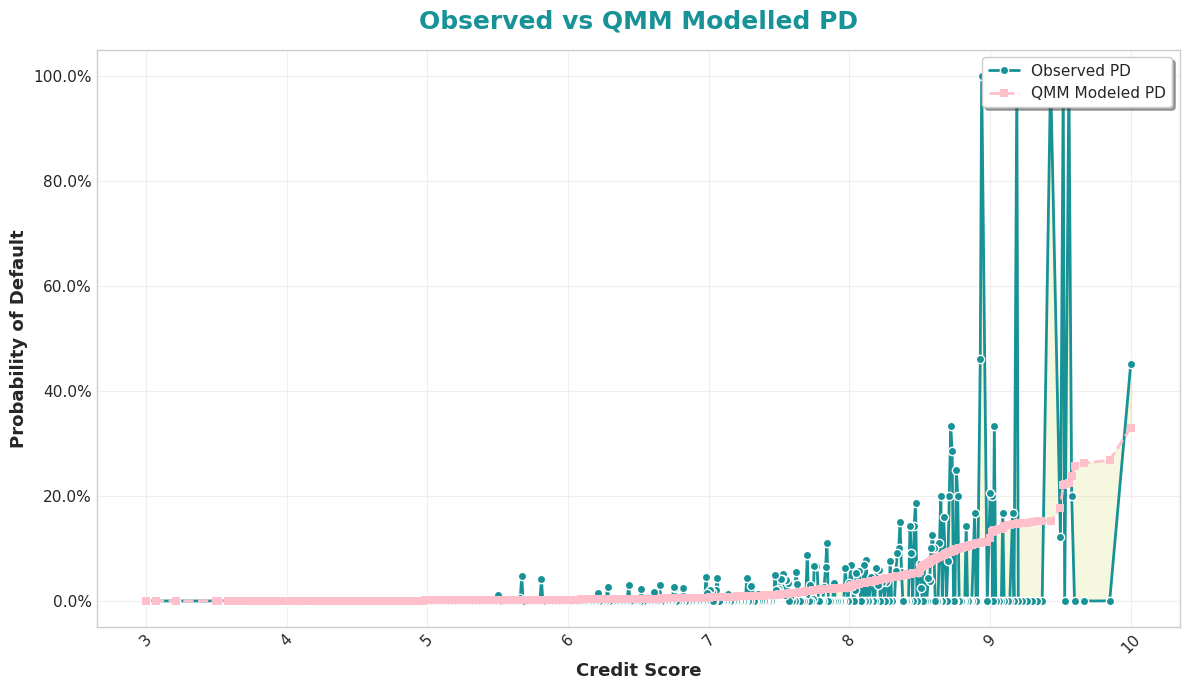



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 15891 entries, 0 to 19595
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 15891 non-null  int64  
 1   DTPOSICAO               15891 non-null  object 
 2   I_Est_Def12m_PES_FINAL  15891 non-null  int64  
 3   Rating_Final_Corrected  15891 non-null  object 
 4   Score_Corrected         15891 non-null  float64
 5   undrawn                 15891 non-null  object 
 6   R_ST                    15891 non-null  object 
 7   DES1                    15891 non-null  int64  
 8   DES2                    15891 non-null  int64  
 9   DES3                    15891 non-null  int64  
 10  DES4                    15891 non-null  int64  
 11  DES5                    15891 non-null  int64  
 12  DES6                    15891 non-null  object 
dtypes: float64(1), int64(7), obje

SynapseWidget(Synapse.DataFrame, 2d97de8a-ad6f-4e65-81db-d28713b0b50f)

SynapseWidget(Synapse.DataFrame, 9a2a29e5-0738-4ae6-8b0e-685f0da09645)




################### CHALLENGE DES5 ##########################


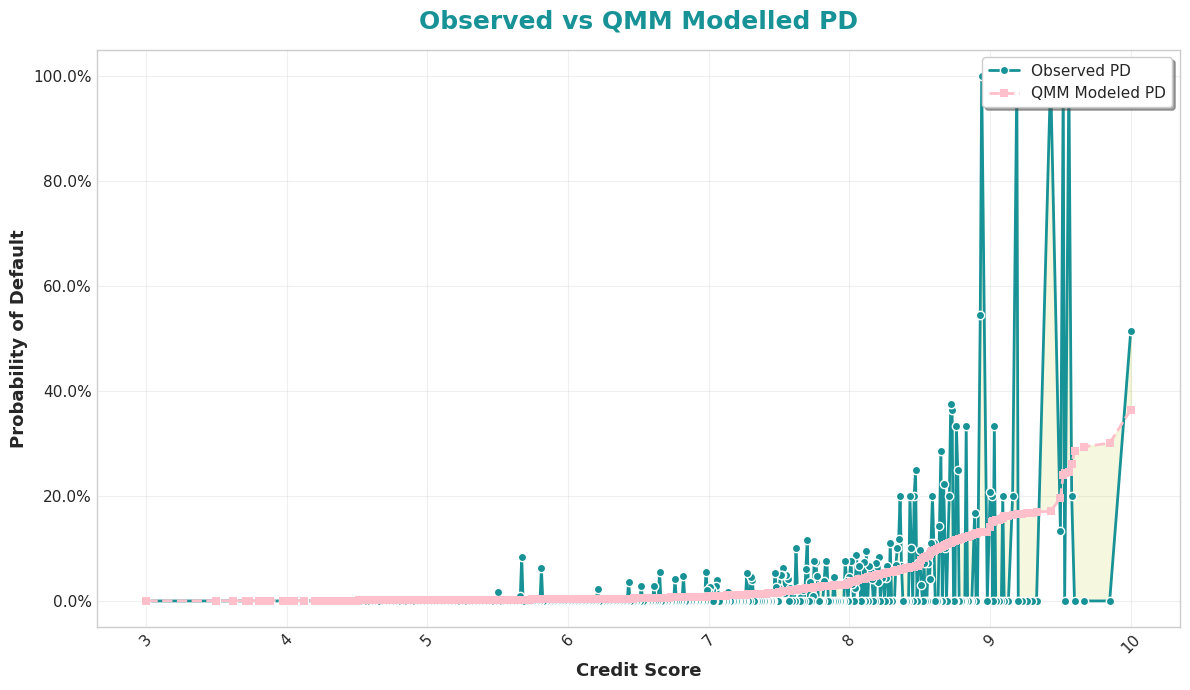



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
Index: 10863 entries, 0 to 19595
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 10863 non-null  int64  
 1   DTPOSICAO               10863 non-null  object 
 2   I_Est_Def12m_PES_FINAL  10863 non-null  int64  
 3   Rating_Final_Corrected  10863 non-null  object 
 4   Score_Corrected         10863 non-null  float64
 5   undrawn                 10863 non-null  object 
 6   R_ST                    10863 non-null  object 
 7   DES1                    10863 non-null  int64  
 8   DES2                    10863 non-null  int64  
 9   DES3                    10863 non-null  int64  
 10  DES4                    10863 non-null  int64  
 11  DES5                    10863 non-null  int64  
 12  DES6                    10863 non-null  object 
dtypes: float64(1), int64(7), obje

SynapseWidget(Synapse.DataFrame, c754d9bd-8fd5-4cdb-8879-cb8cfb39756f)

SynapseWidget(Synapse.DataFrame, 2d53915f-08ff-4a1c-b9a0-40c74297175a)

In [17]:
# Lista dos desafios
desafios = [f"DES{i}" for i in range(1, 6)]

for d in desafios:
    print(f"\n\n\n################### CHALLENGE {d} ##########################")
  
    # Filtrar dados
    df_ch = df[df[d] == 1]

    # Calcular CT target (LRADR)
    LRA_DR = df_ch.groupby("Posicao").agg(
        DR=('I_Est_Def12m_PES_FINAL', 'mean'),
        count=('I_Est_Def12m_PES_FINAL', 'size')
    )["DR"].mean()

    # Rodar QMM
    # final file name, df_input, ct_target, ar_target
    qmm_results, results = run_QMM(f"QMM portfolio {d}", df_ch, LRA_DR, None)


# Desafio 6

StatementMeta(, 7bdff5cd-2007-408f-9b34-f17b05f1cda6, 21, Finished, Available, Finished)

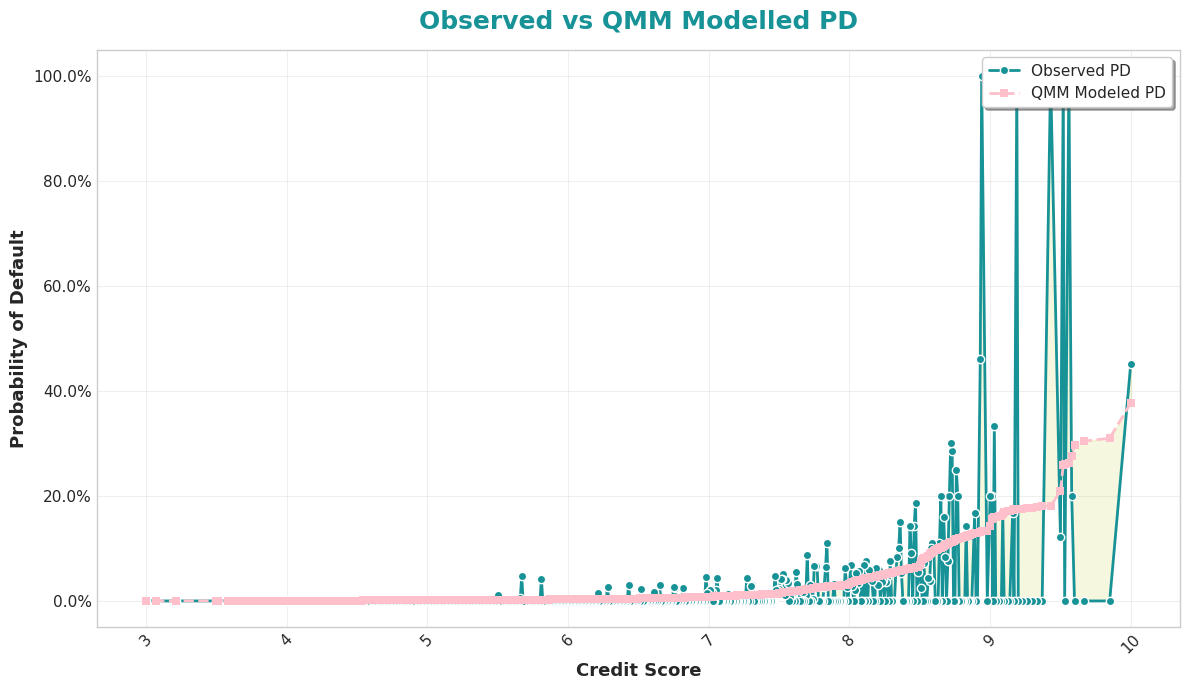



********************* DATA QUALITY CHECKS *********************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19599 entries, 0 to 19598
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Posicao                 19599 non-null  int64  
 1   DTPOSICAO               19599 non-null  object 
 2   I_Est_Def12m_PES_FINAL  19599 non-null  int64  
 3   Score_Corrected         15936 non-null  float64
 4   undrawn                 19599 non-null  object 
 5   R_ST                    19599 non-null  object 
 6   DES1                    19599 non-null  int64  
 7   DES2                    19599 non-null  int64  
 8   DES3                    19599 non-null  int64  
 9   DES4                    19599 non-null  int64  
 10  DES5                    19599 non-null  int64  
 11  Rating_Final_Corrected  19599 non-null  object 
dtypes: float64(1), int64(7), object(4)
memory usage: 1.8+ MB

-------------------

SynapseWidget(Synapse.DataFrame, c189205a-69ec-40e2-b612-a1accbb617f7)

SynapseWidget(Synapse.DataFrame, fdf2dd79-1cdc-4569-bf46-24c47fa42538)

In [19]:
df_ch6 = df.drop(columns=['Rating_Final_Corrected'])
df_ch6 = df_ch6.rename(columns={'DES6': 'Rating_Final_Corrected'})

LRA_DR6 = df_ch6.groupby("Posicao").agg(
    DR=('I_Est_Def12m_PES_FINAL', 'mean'),
    count=('I_Est_Def12m_PES_FINAL', 'size')
)["DR"].mean()

qmm_results, results = run_QMM(f"QMM portfolio {d}", df_ch6, LRA_DR6, None)

StatementMeta(, 7bdff5cd-2007-408f-9b34-f17b05f1cda6, 20, Finished, Available, Finished)